# Ancillary Datasets

In order to use external/ancillary datasets as feature layers in the crop ML model, we need to resample the datasets to match Sentinel2.  The code here tests the workflow for resampling.  

Also testing creating a slope layer.

`xr_reproject` is a new function and needs to be installed manually as per below: 

     !pip install -U --no-deps --extra-index-url="https://packages.dea.ga.gov.au" odc-algo

### Try reprojecting CHIRPS

Issue with `.geobox` expecting lat/lon as coords rather than xy, will be fixed in `ODC1.8.1`. Code currently works on the `unstable` sandbox

Created an `annual cumulative rainfall climatology` for the world (`'data/CHIRPS/CHP_clim_sum.nc'`):

    z = []
    for i in os.listdir('data/CHIRPS/'):
        x = assign_crs(xr.open_rasterio('data/CHIRPS/'+ i))
        z.append(x)

    a = xr.concat(z, dim='band').where(a>-10).sum('band').where(a>0)

In [1]:
from odc.algo import xr_reproject
from datacube.utils.geometry import assign_crs
import xarray as xr
import datacube
import os
import sys
import numpy as np
# sys.path.append('../Scripts')
# from deafrica_datahandling import load_ard
# # from deafrica_dask import create_local_dask_cluster

## Cumulative Rainfall

Prerequisites: download monthly global CHIRPS 2.0 rainfall data, for example from the [USGS website](https://earlywarning.usgs.gov/fews/datadownloads/Global/CHIRPS%202.0). They will likely be in `.tif` format and around 55 MB each. They should be stored at a folder created at the directory `data/CHIRPS/`.

In [2]:
x = os.listdir('data/CHIRPS/')
#c=[x[0]]+x[2:]
#c.sort()

# Lists files in alphabetical order
c=sorted(x)

### Jan-->Apr (`ja`)

In [3]:
# Inspect file list - depending on 
# gitignore settings, may need to adjust index or remove files from folder

c[1:5]

['chirps-v2.0.2019.01.tif',
 'chirps-v2.0.2019.02.tif',
 'chirps-v2.0.2019.03.tif',
 'chirps-v2.0.2019.04.tif']

In [4]:
z = []
for i in c[1:5]:
    x = assign_crs(xr.open_rasterio('data/CHIRPS/'+ i))
    z.append(x)

ja = xr.concat(z, dim='band')
ja = ja.where(ja>-10).sum('band')
ja = ja.where(ja>0)

/env/lib/python3.6/site-packages/pyproj/crs/crs.py:280: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(projparams)


In [5]:
# File path has been moved outside the ancillary dataset folder to avoid jumbling the file path order

ja.to_netcdf('data/CHPclim_jan_apr_cumulative_rainfall.nc')

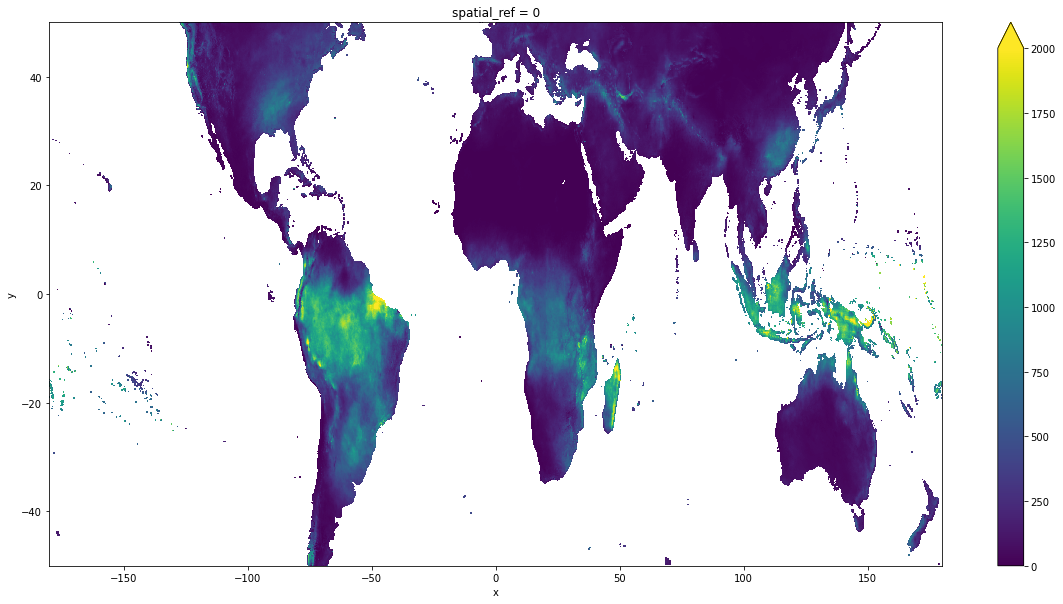

In [6]:
ja.plot(figsize=(20,10),vmax=2000, vmin=0);

### May --> Aug

In [7]:
c[5:9]

['chirps-v2.0.2019.05.tif',
 'chirps-v2.0.2019.06.tif',
 'chirps-v2.0.2019.07.tif',
 'chirps-v2.0.2019.08.tif']

In [8]:
z = []
for i in c[5:9]:
    x = assign_crs(xr.open_rasterio('data/CHIRPS/'+ i))
    z.append(x)

ma = xr.concat(z, dim='band')
ma = ma.where(ma>-10).sum('band')
ma = ma.where(ma>0)

In [9]:
ma.to_netcdf('data/CHPclim_may_aug_cumulative_rainfall.nc')

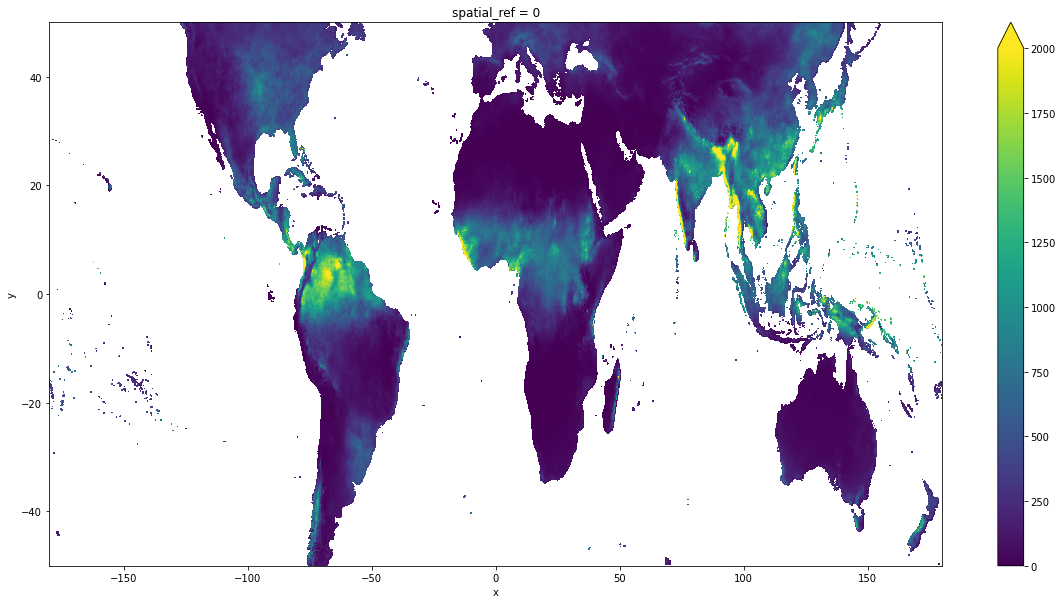

In [10]:
ma.plot(figsize=(20,10),vmax=2000, vmin=0);

### Sep --> Dec (`sd`)

In [11]:
# Inspect file list - depending on 
# gitignore settings, may need to adjust index

c[9:13]

['chirps-v2.0.2019.09.tif',
 'chirps-v2.0.2019.10.tif',
 'chirps-v2.0.2019.11.tif',
 'chirps-v2.0.2019.12.tif']

In [12]:
z = []
for i in c[9:13]:
    x = assign_crs(xr.open_rasterio('data/CHIRPS/'+ i))
    z.append(x)

sd = xr.concat(z, dim='band')
sd = sd.where(sd>-10).sum('band')
sd = sd.where(sd>0)

In [13]:
# File path has been moved outside the ancillary dataset folder to avoid jumbling the file path order

sd.to_netcdf('data/CHPclim_sep_dec_cumulative_rainfall.nc')

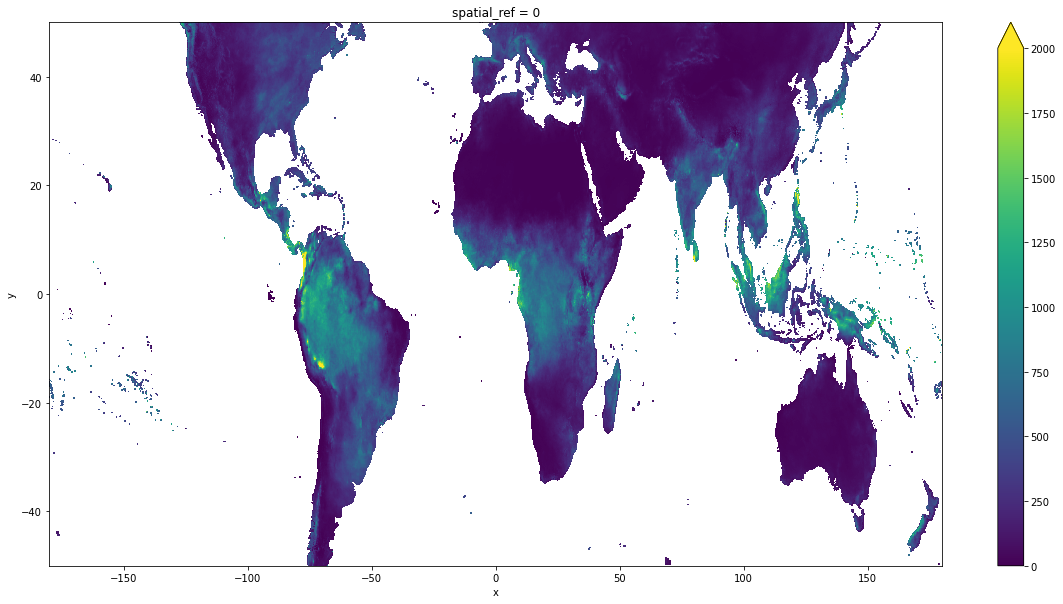

In [14]:
sd.plot(figsize=(20,10),vmax=2000, vmin=0);

## reprojection

In [ ]:
dc = datacube.Datacube(app='reprojection')

# Define area of interest
lat = 24.842#22.817
lon = 13.004#28.518
lon_buffer = 1.0 #0.0175
lat_buffer = 1.0 #0.004

# Combine central lat,lon with buffer to get area of interest
lat_range = (lat-lat_buffer, lat+lat_buffer)
lon_range = (lon-lon_buffer, lon+lon_buffer)

# Set the range of dates for the analysis
years_range = ('2018-01-01', '2018-01-05')

In [ ]:
# Create a reusable query
query = {
    'y': lat_range,
    'x': lon_range,
    'time': years_range,
    'measurements': ['red'],
    'resolution': (-20,20),
    'output_crs': 'epsg:6933',
    'dask_chunks': {'x':1000, 'y':1000}
}

# Load available data from S2
ds = dc.load(product='s2_l2a',
              **query,
              )

print(ds)

In [ ]:
chirps=assign_crs(xr.open_rasterio('data/CHIRPS/CHPclim_sum.nc'),  crs='epsg:4326')
chirps

In [ ]:
chirps_20m = xr_reproject(chirps,
                         ds.geobox,
                         "mode",
                            )

chirps_20m = assign_crs(chirps_20m, crs=ds.geobox.crs)

In [ ]:
chirps_20m.isel(x=slice(0,4000)).plot(figsize=(10,10))

## Calculate Slope on SRTM

    !pip install richdem

In [ ]:
import os
import datacube
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import richdem as rd
import pyproj
import xarray as xr


In [ ]:
lat, lon = -3.064, 37.359
buffer = 0.1

query = {
    'x': (lon-buffer, lon+buffer),
    'y': (lat+buffer, lat-buffer),
    'output_crs': 'EPSG:6933',
    'resolution': (-30, 30)
}

dc = datacube.Datacube(app='slope')

#load data
da = dc.load(product ='srtm', **query)
da = da.elevation

In [ ]:
def xr_terrain(da, attribute=None):
    """
    Using the richdem package, calculates terrain attributes
    on a DEM stored in memory as an xarray.DataArray 
    
    Params
    -------
    da : xr.DataArray
    attribute : str
        One of the terrain attributes that richdem.TerrainAttribute()
        has implemented. e.g. 'slope_riserun', 'slope_percentage', 'aspect'.
        See all option here:  
        https://richdem.readthedocs.io/en/latest/python_api.html#richdem.TerrainAttribute
        
    """
    #remove time if its there
    da = da.squeeze()
    #convert to richdem array
    rda = rd.rdarray(da.data, no_data=da.attrs['nodata'])
    #add projection and geotransform
    rda.projection=pyproj.crs.CRS(da.attrs['crs']).to_wkt()
    rda.geotransform = da.geobox.affine.to_gdal()
    #calulate attribute
    attrs = rd.TerrainAttribute(rda, attrib=attribute)

    #return as xarray DataArray
    return xr.DataArray(attrs,
                        attrs=da.attrs,
                        coords={'x':da.x, 'y':da.y},
                        dims=['y', 'x'])

In [ ]:
%%time
slope = xr_terrain(da, 'slope_riserun')

In [ ]:
slope.plot(cmap='magma', figsize=(8,8), robust=True);